In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from shapely import wkt
import os
import rasterio.mask
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import hashlib
tqdm.pandas()


In [4]:
# Potentiel solaire package
from potentiel_solaire.constants import DATA_FOLDER
from potentiel_solaire.features.roof_attributes import recuperation_mnh_batiment, recuperation_mns_batiment, recuperation_flux_wms

In [5]:
# Executer ci dessous ci besoin pour récupérer les données
# !extract-sample-data
# Et pour sauver une version markdown des notebooks, utiliser
# jupyter nbconvert wns_hauteur.ipynb --to markdown --output-dir=exports/

In [6]:
saint_denis_path = DATA_FOLDER / "saint_denis_reference_data.gpkg"
batiments = gpd.read_file(saint_denis_path, layer="bdtopo_batiment").to_crs(2154)
batiments = batiments.to_crs(2154)

# Testing caching


In [28]:
def get_cached_wns(row, layer, cache = True):
    boite = row.total_bounds
    x = int((boite[2]-boite[0])*2)
    y= int((boite[3]-boite[1])*2)
    
    layer_hash = hashlib.md5(layer.encode()).hexdigest()[:8]
    wkts = wkt.dumps(batiments[0:1].geometry.iloc[0])
    wkts = hashlib.md5(wkts.encode()).hexdigest()[:8]
    filename = f'{wkts}.tiff'

    path_to_wns_cache = DATA_FOLDER / "cache" /"wns"/ layer_hash
    path_to_wns_cache.mkdir(parents=True, exist_ok=True)
    wns_data_path = path_to_wns_cache / filename

    if not os.path.isfile(str(wns_data_path)) or (not cache):

        flux = recuperation_flux_wms(boite, layer = layer, srs =  'EPSG:2154',
                        X= x,Y= y)
        with open(wns_data_path, 'wb') as out:
            out.write(flux.read())

    with rasterio.open(wns_data_path) as img:
        data, _ = rasterio.mask.mask(img, row.geometry, crop=True)
    return data

In [ ]:
# Takes 2s
get_cached_wns(batiments[0:1], layer = "ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES", cache=False)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], shape=(1, 76, 50), dtype=float32)

In [ ]:
# Takes 0.0s
get_cached_wns(batiments[0:1], layer = "ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES", cache=True)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], shape=(1, 76, 50), dtype=float32)

# Back to no cache

In [ ]:
def getMesureMNHToit(row, cache_file="cache.gpkg", layercache="cache_hauteur",
                     valeur="hauteur_calculee"):

    values = ["hauteur_calculee", "hauteur_std-dev", "hauteur_min",
              "hauteur_max", "hauteur_median","mns_std-dev"]
    if valeur not in values:
        return -1
    row = gpd.GeoDataFrame(row).T
    row = gpd.GeoDataFrame(row, geometry="geometry")
    if "cleabs_left__bat" in row.columns:
        row = row.rename(columns={"cleabs_left__bat": "cleabs"})
    cache_h = DATA_FOLDER / cache_file

    if os.path.isfile(str(cache_h)):
        gdf = gpd.read_file(cache_h, layer=layercache)
        existing = gdf["cleabs"].unique()
    else:
        existing = []
    row = row[["cleabs", "hauteur", "geometry"]]

    cols = ["cleabs", "hauteur_calculee", "hauteur", "geometry",
            "hauteur_std-dev", "hauteur_min", "hauteur_max", "hauteur_median","mns_std-dev"]

    if row["cleabs"].iloc[0] in existing:
        v = gdf[gdf.cleabs == row["cleabs"].iloc[0]][valeur].iloc[0]
        return v
    else:
        mnh = recuperation_mnh_batiment(row)
        mns = recuperation_mns_batiment(row)
        row["hauteur_calculee"] = np.average(mnh[np.nonzero(mnh)])
        row["hauteur_std-dev"] = np.std(mnh[np.nonzero(mnh)])
        row["mns_std-dev"] = np.std(mns[np.nonzero(mns)])
        row["hauteur_min"] = np.min(mnh[np.nonzero(mnh)])
        row["hauteur_max"] = np.max(mnh[np.nonzero(mnh)])
        row["hauteur_median"] = np.median(mnh[np.nonzero(mnh)])

        if len(existing):
            gtotal = pd.concat([gdf, row[cols]])
            gtotal.to_file(cache_h, layer=layercache, driver="GPKG")
        else:
            gtotal = row[cols]
            gtotal.to_file(cache_h, layer=layercache, driver="GPKG")

    return row[valeur]


#### Test sur les batiments de St Denis, qui n'ont pas de hauteur

In [10]:
batiments_de_test = pd.concat([batiments[batiments.hauteur.isna()].head(50),batiments[~batiments.hauteur.isna()].head(50)]).to_crs(2154)
for measure in ["hauteur_calculee", "hauteur_std-dev","mns_std-dev"]:
    batiments_de_test[measure] = \
        batiments_de_test.progress_apply(lambda batiment:\
        getMesureMNHToit(batiment, valeur=measure), axis = 1)
# Pourquoi du caching? Les calls prennent 5s par batiment sans cache ce qui impacte le temps de calcul
batiments_de_test[["cleabs_left__bat","hauteur","hauteur_calculee", "hauteur_std-dev","mns_std-dev"]]

100%|██████████| 100/100 [00:04<00:00, 23.44it/s]


,cleabs_left__bat,hauteur,hauteur_calculee,hauteur_std-dev,mns_std-dev
3,BATIMENT0000000243403399,NaN,11.029757,0.067987,0.067987
4,BATIMENT0000000243403625,NaN,6.658521,2.384741,2.401657
9,BATIMENT0000000243399213,NaN,9.085352,3.031133,3.039754
21,BATIMENT0000000243399192,NaN,15.689178,0.720638,0.747832
22,BATIMENT0000000243399193,NaN,8.944949,3.632601,3.621020
...,...,...,...,...,...
57,BATIMENT0000002005316846,8.8,8.908059,2.549423,2.561931
58,BATIMENT0000000318256795,2.7,4.304110,3.272367,3.270343
59,BATIMENT0000000243401942,9.3,10.166159,3.535393,3.419895
60,BATIMENT0000000243401947,13.0,12.285078,2.676683,2.704555


#### Les erreurs sont "elevées" sur les petits batiments, la précision est meilleure sur les plus grands bâtiments

In [11]:
check = batiments_de_test[~batiments_de_test.hauteur.isna()]

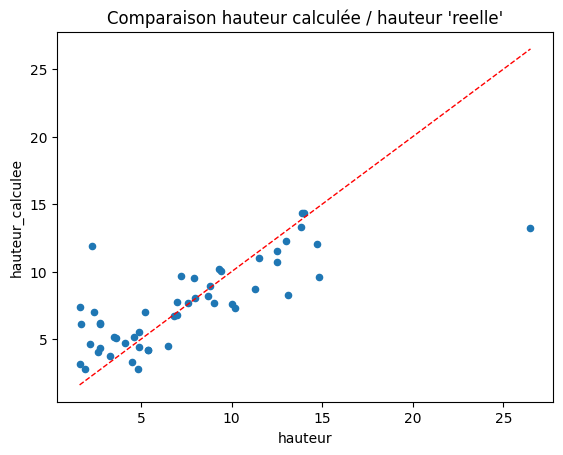

In [12]:
identity_line = np.linspace(check.hauteur.min(),
                            check.hauteur.max())

check.plot.scatter(x="hauteur",y="hauteur_calculee",title="Comparaison hauteur calculée / hauteur 'reelle'")
plt.plot(identity_line, identity_line, color="red", linestyle="dashed", linewidth=1.0)

#### Représentation des erreurs

In [13]:
def getAccuracy(row):
    acc = np.abs(row["hauteur"]-row["hauteur_calculee"])/np.abs(row["hauteur"])
    return float(acc)

In [14]:
check["difference"] = check.apply(lambda batiment: getAccuracy(batiment), axis = 1)

/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: title={'center': 'Erreur en fonction de la hauteur\nErreur sur les toits de plus de 4 mètres: 16%'}, xlabel='hauteur', ylabel='difference'>

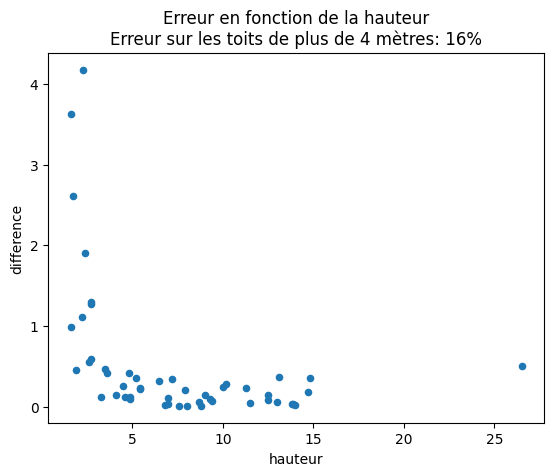

In [15]:
detail = "Erreur sur les toits de plus de 4 mètres: "+str(int(100*check["difference"][check.hauteur > 4 ].mean()))+"%"
check.plot.scatter(x="hauteur",y="difference",title="Erreur en fonction de la hauteur\n"+detail)

#### Test avec les pentes de toit

In [16]:
toits = gpd.read_file(saint_denis_path, layer="potentielsolaire_toitures").to_crs(2154)
toits = toits[toits.id.isin(check.cleabs_left__bat.unique())][["id","forme"]]
# can be "hauteur_std-dev" instead of mns to get mnh instead of mns
dataset_test = check[["cleabs_left__bat","mns_std-dev","hauteur_calculee"]]
dataset_test.columns = ["id","stdev","h"]
toits = toits.merge(dataset_test,on="id",how="inner")

#### test non concluant..

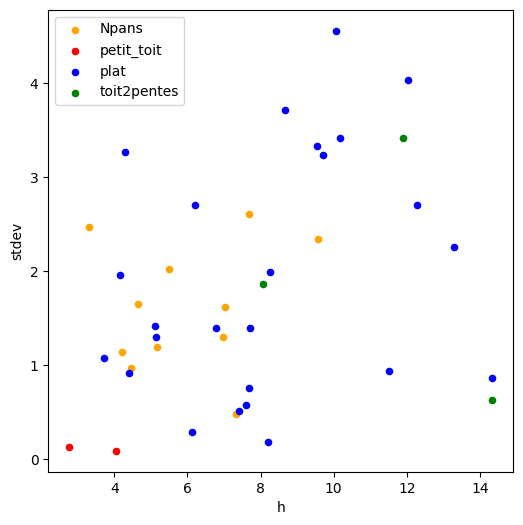

In [17]:
colors = {'plat':'blue', 'Npans':'orange', 'toit2pentes':'green', 'petit_toit':'red'}

fig, ax = plt.subplots(figsize=(6, 6))
grouped = toits.groupby('forme')
for key, group in grouped:
    group.plot.scatter(ax=ax, x='h', y='stdev', label=key, color=colors[key])
plt.show()